<a href="https://colab.research.google.com/github/claredavies/ArtificialIntelligience/blob/main/WeLoveComputationalIntelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install scikit-fuzzy
!pip install tabulate
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import collections
from collections import OrderedDict


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


# Solving 3.2

In [2]:
def yp_solver(x):
  res = 0.2 * np.sin(2*np.pi*x + np.pi/4) + 0.5
  return res

def membership_solver_with_k(x, j_val, k_val):
  b_k = 1/(k_val - 1)
  a_j_k = (j_val-1)/(k_val-1)
  res = max(1-np.abs(x-a_j_k)/b_k, 0)
  return res

def yxp_solver(xp_val, b_vals, k_val=5):
  # this is the numerator
  numerator = 0
  for i in range(k_val):
    cur = membership_solver_with_k(xp_val, i+1, k_val) * b_vals[i]
    numerator += cur
  # this is the denominator
  denominator = 0
  for i in range(k_val):
    cur = membership_solver_with_k(xp_val, i+1, k_val)
    denominator += cur
  res = numerator/denominator
  return res

def performance_index(x_arr, yps, b_vals, k_val=5):
  m = len(x_arr)
  res = 0
  for p in range(m):
    res += (np.power(yxp_solver(x_arr[p], b_vals, k_val) - yps[p], 2))/2
  return res

def weight_calc(xp_val, j, alpha=10, k_val=5):
  # this is the μ 
  membership_value = membership_solver_with_k(xp_val, j, k_val)
  # this is the weight for j
  res = np.power(membership_value, alpha)
  return res

def b_calc(xps, yps, j, alpha=10, k_val=5):
  m = len(xps)
  # this is the numerator
  numerator = 0
  for p in range(0, m):
    weight_p = weight_calc(xps[p], j, alpha, k_val)
    weight_p_multiply_yp = weight_p * yps[p]
    numerator += weight_p_multiply_yp
  # this is the denominator 
  denominator = 0
  for p in range(0, m):
    weight_p = weight_calc(xps[p], j, alpha, k_val)
    denominator += weight_p
  res = numerator/denominator
  return res

# Solving 4.2

### The formulas being implemented are as follow, 
The number inside the brackets () will be the formula definition according to the paper, for example Formula (1) would be the input-output pair in page 2 from the paper

#### Formula for (3), Membership solver
![Formula no. 3](./assets/formulas/formula_3.png)

In [3]:
def membership_solver(x, j_val, k_val):
    b_k = 1 / (k_val - 1)
    a_j_k = (j_val - 1) / (k_val - 1)
    mmebership_value = max(1 - np.abs(x - a_j_k) / b_k, 0)
    return mmebership_value

#### Formula for (7), y(xp) solver
![Formula no. 7](./assets/formulas/formula_7.png)

In [4]:
def yxp_solver(x1_val, x2_val, b_dict, k1_val, k2_val):
    numerator, denominator = 0, 0
    for j1 in range(k1_val):
        for j2 in range(k2_val):
            membership_value = membership_solver(
                x1_val, j1 + 1, k1_val
            ) * membership_solver(x2_val, j2 + 1, k2_val)
            numerator += membership_value * b_dict[j1 + 1][j2 + 1]
            denominator += membership_value
    yxp_value = numerator / denominator
    return yxp_value

#### Formula for (9), Weight W(xp) solver
![Formula no. 9](./assets/formulas/formula_9.png)

In [5]:
def weight_calc(xp1_val, xp2_val, j1, j2, alpha, k1_val, k2_val):
    membership_value = membership_solver(xp1_val, j1, k1_val) * membership_solver(
        xp2_val, j2, k2_val
    )

    weight_value = np.power(membership_value, alpha)
    return weight_value

#### Formula for (10), consequent real number b solver
![Formula no. 10](./assets/formulas/formula_10.png)

In [6]:
def b_calc(x1, x2, yps, j1, j2, alpha, k1_val, k2_val):
    m = len(x1)
    numerator = 0
    denominator = 0
    for p in range(0, m):
        weight_p = weight_calc(x1[p], x2[p], j1, j2, alpha, k1_val, k2_val)
        numerator += weight_p * yps[p]
        denominator += weight_p
    b_value = numerator / denominator
    return b_value

#### Formula for (16), B star membership value solver
![Formula no. 16](./assets/formulas/formula_16.png)

In [7]:
def get_label(class_key, k_val):
    if k_val > 5 or k_val==1:
        raise Exception('Implementation only support k value from 2 to 5')
    if k_val == 5:
        label_dict = {1: "S", 2: "MS", 3: "M", 4: "ML", 5: "L"}
    if k_val == 4:
        label_dict = {1: "S", 2: "MS", 3: "M", 4: "L"}
    if k_val == 3:
        label_dict = {1: "S", 2: "M", 3: "L"}
    if k_val == 2:
        label_dict = {1: "S", 2: "L"}
    label = label_dict[class_key]
    return label


def get_centroid(j_val, k_val):
    centroid = (j_val - 1) / (k_val - 1)
    return centroid


def membership_solver_with_two_tables(x, k_val):
    result = {}
    res_arr = []
    for j_i in range(1, k_val + 1):
        res = membership_solver(x, j_i, k_val)
        res_arr.append(res)
    max_value = max(res_arr)
    second_max_value = sorted(list(res_arr))[-2]

    max_index = res_arr.index(max_value)
    second_max_index = res_arr.index(second_max_value)

    max_class = get_label(max_index + 1, k_val)
    second_max_class = get_label(second_max_index + 1, k_val)

    max_centroid = get_centroid(max_index + 1, k_val)
    second_max_centroid = get_centroid(second_max_index + 1, k_val)

    result["max_class"] = max_class
    result["max_value"] = max_value
    result["max_centroid"] = max_centroid
    result["second_max_class"] = second_max_class
    result["second_max_value"] = second_max_value
    result["second_max_centroid"] = second_max_centroid
    return result

#### Formula for (24), y(xp) solver using the two rule tables
![Formula no. 24](./assets/formulas/formula_24.png)

In [8]:
def yxp_solver_with_centroid(b_dict, xp1, xp2, k1_val, k2_val, b_k_val):
    y = 0
    numerator = 0
    denominator = 0
    for j1 in range(k1_val):
        for j2 in range(k2_val):
            b_j1_j2_val = b_dict[j1 + 1][j2 + 1]
            result = membership_solver_with_two_tables(b_j1_j2_val, b_k_val)
            membership_value = membership_solver(
                xp1, j1 + 1, k1_val
            ) * membership_solver(xp2, j2 + 1, k2_val)
            numerator += (
                membership_value * result["max_centroid"] * result["max_value"]
                + membership_value
                * result["second_max_centroid"]
                * result["second_max_value"]
            )
            denominator += (
                membership_value * result["max_value"]
                + membership_value * result["second_max_value"]
            )

    y = numerator / denominator
    return y

#### Formula for (11), Performance index PI solver
![Formula no. 11](./assets/formulas/formula_11.png)

In [9]:
def performance_index(x1, x2, yps, b_dict, k1_val, k2_val):
    m = len(x1)
    pi_value = 0
    for p in range(m):
        pi_value += (
            np.power(yxp_solver(x1[p], x2[p], b_dict, k1_val, k2_val) - yps[p], 2)
        ) / 2
    return pi_value

def performance_index_with_centroid(x1, x2, yps, b_dict, k1_val, k2_val, b_k_val):
    m = len(x1)
    performance_index = 0
    for p in range(m):
        yxp_value = (
            np.power(
                yxp_solver_with_centroid(b_dict, x1[p], x2[p], k1_val, k2_val, b_k_val)
                - yps[p],
                2,
            )
        ) / 2
        performance_index += yxp_value
    return performance_index

#### Additional utilization formulas

In [10]:
def normalize_data(data):
    return np.round((data - np.min(data)) / (np.max(data) - np.min(data)), 2)

def generate_b_table(x1, x2, yp_orig, k_value, alpha):
    b_dict = {}
    for x in range(1, (k_value + 1), 1):
        b_dict[x] = {}
    for i in range(k_value):
        for j in range(k_value):
            res = b_calc(x1, x2, yp_orig, i + 1, j + 1, alpha, k_value, k_value)
            b_dict[i + 1][j + 1] = res
    return b_dict

def generate_main_dict(b_dict, k_value):
    main_dict = {}
    for x in range(1, (k_value + 1), 1):
        main_dict[x] = {}
    for i in range(k_value):
        for j in range(k_value):
            b_j1_j2_val = b_dict[i + 1][j + 1]
            result = membership_solver_with_two_tables(b_j1_j2_val, k_value)
            main_dict[i + 1][j + 1] = result["max_class"]
    return main_dict


def generate_secondary_dict(b_dict, k_value):
    second_dict = {}
    for x in range(1, (k_value + 1), 1):
        second_dict[x] = {}
    for i in range(k_value):
        for j in range(k_value):
            b_j1_j2_val = b_dict[i + 1][j + 1]
            result = membership_solver_with_two_tables(b_j1_j2_val, k_value)
            second_dict[i + 1][j + 1] = result["second_max_class"]
    return second_dict

# Generate Data

In [11]:
df = pd.read_csv('flightData.csv')

In [12]:
# Dataset load
display(df.keys())
x1 = df["Distance(km)"].to_numpy()
x2 = df["#. days left"].to_numpy()
yp = df["Price($)"].to_numpy()

# Data normalization
x1 = normalize_data(x1)
x2 = normalize_data(x2)
yp = normalize_data(yp)

Index(['Unnamed: 0', 'Distance(km)', '#. days left', 'Price($)'], dtype='object')

# Compare different value of K and alpha

In [13]:
list_k = []
list_alpha = []
list_performance_index = []

values_alpha = [0.1, 0.5, 1, 5, 10, 50, 100]

startK = 2
endK = 5

for k in range(startK, (endK + 1), 1):
    for alpha in values_alpha:
        b_dict = generate_b_table(x1, x2, yp, k, alpha)
        perf_index = performance_index_with_centroid(x1, x2, yp, b_dict, k, k, k)
        list_k.append(k)
        list_alpha.append(alpha)
        list_performance_index.append(perf_index)

df_k_alpha_performance_index = pd.DataFrame(
    {"K": list_k, "Alpha": list_alpha, "Performance Index": list_performance_index}
)


In [14]:
print(df_k_alpha_performance_index) 

    K  Alpha  Performance Index
0   2    0.1           1.323934
1   2    0.5           0.983271
2   2    1.0           0.762521
3   2    5.0           0.463662
4   2   10.0           0.729979
5   2   50.0           1.040053
6   2  100.0           1.042856
7   3    0.1           0.473744
8   3    0.5           0.355452
9   3    1.0           0.278765
10  3    5.0           0.227710
11  3   10.0           0.277159
12  3   50.0           0.342215
13  3  100.0           0.343683
14  4    0.1           0.256790
15  4    0.5           0.160427
16  4    1.0           0.093617
17  4    5.0           0.033718
18  4   10.0           0.038461
19  4   50.0           0.044636
20  4  100.0           0.045653
21  5    0.1           0.096385
22  5    0.5           0.053538
23  5    1.0           0.032957
24  5    5.0           0.007644
25  5   10.0           0.007983
26  5   50.0           0.012779
27  5  100.0           0.013991


In [15]:
minvalue_series = df_k_alpha_performance_index.min(skipna = False)
print("Minium value of performance index: " + str(minvalue_series[2]))

Minium value of performance index: 0.007644384829792153


# Set K and alpha variables

In [16]:
K = 5
alpha = 5

# Linguistic Labels for K = 5 (optimum chosen) 

In [17]:
def createLinguisticLabels(range_values, k):
    label_list = []
    centroid_list = []
    start_list = []
    end_list = []

    for x in range(1, (k + 1), 1):
        slot = (np.max(range_values) - np.min(range_values)) / (k - 1)
        start_centroid = np.min(range_values)

        if x == 1:
            start = 0
            centroid = start_centroid
            end = start + slot

        elif x == k:
            centroid = np.max(range_values)
            end = centroid
            start = end - slot

        else:
            centroid = start_centroid + (x - 1) * slot
            start = centroid - slot
            end = centroid + slot

        label_list.append(x)
        centroid_list.append(centroid)
        start_list.append(start)
        end_list.append(end)

    df = pd.DataFrame(
        list(zip(label_list, centroid_list, start_list, end_list)),
        columns=["label", "centroid", "start", "end"],
    )

    return df

In [18]:
# Generate universe variables
K_labels = K

x1_range = np.arange(0, 1.25, 0.25)
x2_range = np.arange(0, 1.25, 0.25)
y_range  = np.arange(0, 1.25, 0.25)

print(x1_range)

[0.   0.25 0.5  0.75 1.  ]


In [19]:
x1_df = createLinguisticLabels(x1_range, K_labels)
x2_df = createLinguisticLabels(x2_range, K_labels)
y_df = createLinguisticLabels(y_range, K_labels)

In [20]:
print(x1_df)

   label  centroid  start   end
0      1      0.00   0.00  0.25
1      2      0.25   0.00  0.50
2      3      0.50   0.25  0.75
3      4      0.75   0.50  1.00
4      5      1.00   0.75  1.00


In [21]:
# Generate fuzzy membership functions
# start point, y point, end point
x1_s = fuzz.trimf(x1_range, [x1_df["start"][0], x1_df["centroid"][0], x1_df["end"][0]])
x1_ms = fuzz.trimf(x1_range, [x1_df["start"][1], x1_df["centroid"][1], x1_df["end"][1]])
x1_m = fuzz.trimf(x1_range, [x1_df["start"][2], x1_df["centroid"][2], x1_df["end"][2]])
x1_ml = fuzz.trimf(x1_range, [x1_df["start"][3], x1_df["centroid"][3], x1_df["end"][3]])
x1_l = fuzz.trimf(x1_range, [x1_df["start"][4], x1_df["centroid"][4], x1_df["end"][4]])

x2_s = fuzz.trimf(x2_range, [x2_df["start"][0], x2_df["centroid"][0], x2_df["end"][0]])
x2_ms = fuzz.trimf(x2_range, [x2_df["start"][1], x2_df["centroid"][1], x2_df["end"][1]])
x2_m = fuzz.trimf(x2_range, [x2_df["start"][2], x2_df["centroid"][2], x2_df["end"][2]])
x2_ml = fuzz.trimf(x2_range, [x2_df["start"][3], x2_df["centroid"][3], x2_df["end"][3]])
x2_l = fuzz.trimf(x2_range, [x2_df["start"][4], x2_df["centroid"][4], x2_df["end"][4]])

y_s = fuzz.trimf(x1_range, [x1_df["start"][0], x1_df["centroid"][0], x1_df["end"][0]])
y_ms =  fuzz.trimf(x1_range, [x1_df["start"][1], x1_df["centroid"][1], x1_df["end"][1]])
y_m = fuzz.trimf(x1_range, [x1_df["start"][2], x1_df["centroid"][2], x1_df["end"][2]])
y_ml = fuzz.trimf(x1_range, [x1_df["start"][3], x1_df["centroid"][3], x1_df["end"][3]])
y_l = fuzz.trimf(x1_range, [x1_df["start"][4], x1_df["centroid"][4], x1_df["end"][4]])

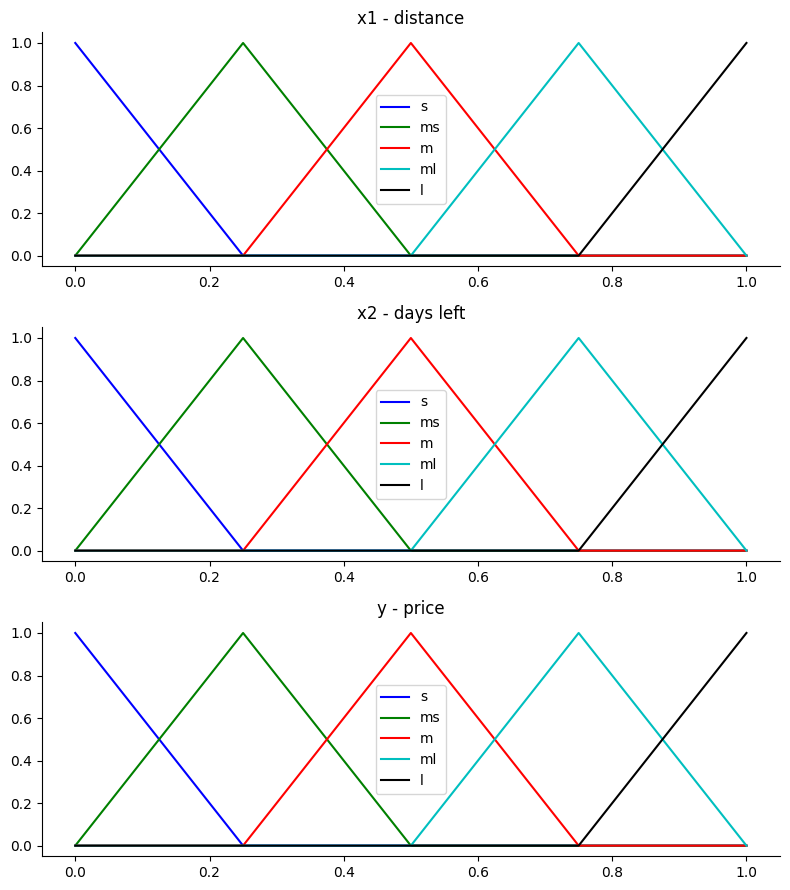

In [22]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x1_range, x1_s, 'b', linewidth=1.5, label='s')
ax0.plot(x1_range, x1_ms, 'g', linewidth=1.5, label='ms')
ax0.plot(x1_range, x1_m, 'r', linewidth=1.5, label='m')
ax0.plot(x1_range, x1_ml, 'c', linewidth=1.5, label='ml')
ax0.plot(x1_range, x1_l, 'k', linewidth=1.5, label='l')
ax0.set_title('x1 - distance')
ax0.legend()


ax1.plot(x2_range, x2_s, 'b', linewidth=1.5, label='s')
ax1.plot(x2_range, x2_ms, 'g', linewidth=1.5, label='ms')
ax1.plot(x2_range, x2_m, 'r', linewidth=1.5, label='m')
ax1.plot(x2_range, x2_ml, 'c', linewidth=1.5, label='ml')
ax1.plot(x2_range, x2_l, 'k', linewidth=1.5, label='l')
ax1.set_title('x2 - days left')
ax1.legend()

ax2.plot(y_range, y_s, 'b', linewidth=1.5, label='s')
ax2.plot(y_range, y_ms, 'g', linewidth=1.5, label='ms')
ax2.plot(y_range, y_m, 'r', linewidth=1.5, label='m')
ax2.plot(y_range, y_ml, 'c', linewidth=1.5, label='ml')
ax2.plot(y_range, y_l, 'k', linewidth=1.5, label='l')
ax2.set_title('y - price')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

# Find b table, main table and secondary table for flight dataset and specified k  alpha

Get b dictionary for data

In [23]:
b_dict = generate_b_table(x1, x2, yp, K, alpha)

print("{" + "\n".join("{!r}: {!r},".format(k, v) for k, v in b_dict.items()) + "}")

{1: {1: 0.64, 2: 0.022125026841160904, 3: 0.027140275570830596, 4: 0.011803750305135866, 5: 0.013841070104032734},
2: {1: 0.6363907955052416, 2: 0.21482354030784614, 3: 0.15237317771766593, 4: 0.10078518318665496, 5: 0.1642691524571328},
3: {1: 0.8868675893764586, 2: 0.3826829233729722, 3: 0.32474719456721096, 4: 0.3101468248225174, 5: 0.3209601523799926},
4: {1: 0.9856935968214833, 2: 0.5658993368986738, 3: 0.48175727221866055, 4: 0.48502294814388613, 5: 0.5090860881996035},
5: {1: 0.63, 2: 0.6291705226919106, 3: 0.6220092513442103, 4: 0.5939829177409353, 5: 0.5105200099561509},}


Get performance index

In [24]:
performance_index_with_centroid(x1, x2, yp, b_dict, K, K, K)

0.007644384829792153

In [25]:
main_dict = generate_main_dict(b_dict, K)
second_dict = generate_secondary_dict(b_dict, K)

In [26]:
display(main_dict)

{1: {1: 'ML', 2: 'S', 3: 'S', 4: 'S', 5: 'S'},
 2: {1: 'ML', 2: 'MS', 3: 'MS', 4: 'S', 5: 'MS'},
 3: {1: 'L', 2: 'M', 3: 'MS', 4: 'MS', 5: 'MS'},
 4: {1: 'L', 2: 'M', 3: 'M', 4: 'M', 5: 'M'},
 5: {1: 'ML', 2: 'ML', 3: 'M', 4: 'M', 5: 'M'}}

In [27]:
display(second_dict)

{1: {1: 'M', 2: 'MS', 3: 'MS', 4: 'MS', 5: 'MS'},
 2: {1: 'M', 2: 'S', 3: 'S', 4: 'MS', 5: 'S'},
 3: {1: 'ML', 2: 'MS', 3: 'M', 4: 'M', 5: 'M'},
 4: {1: 'ML', 2: 'ML', 3: 'MS', 4: 'MS', 5: 'ML'},
 5: {1: 'M', 2: 'M', 3: 'ML', 4: 'ML', 5: 'ML'}}

# Results



In [28]:
upsampled = np.linspace(-2, 2, 21)
x_orig2 = [1, 2, 3, 4, 5]
y_orig2 = [1, 2, 3, 4, 5]
z_dict = {1: {1: 'ML', 2: 'S', 3: 'S', 4: 'S', 5: 'S'},
 2: {1: 'ML', 2: 'MS', 3: 'MS', 4: 'S', 5: 'MS'},
 3: {1: 'L', 2: 'M', 3: 'MS', 4: 'MS', 5: 'MS'},
 4: {1: 'L', 2: 'M', 3: 'M', 4: 'M', 5: 'M'},
 5: {1: 'ML', 2: 'ML', 3: 'M', 4: 'M', 5: 'M'}}
z_dict2 = {1: {1: 'M', 2: 'MS', 3: 'MS', 4: 'MS', 5: 'MS'},
 2: {1: 'M', 2: 'S', 3: 'S', 4: 'MS', 5: 'S'},
 3: {1: 'ML', 2: 'MS', 3: 'M', 4: 'M', 5: 'M'},
 4: {1: 'ML', 2: 'ML', 3: 'MS', 4: 'MS', 5: 'ML'},
 5: {1: 'M', 2: 'M', 3: 'ML', 4: 'ML', 5: 'ML'}}

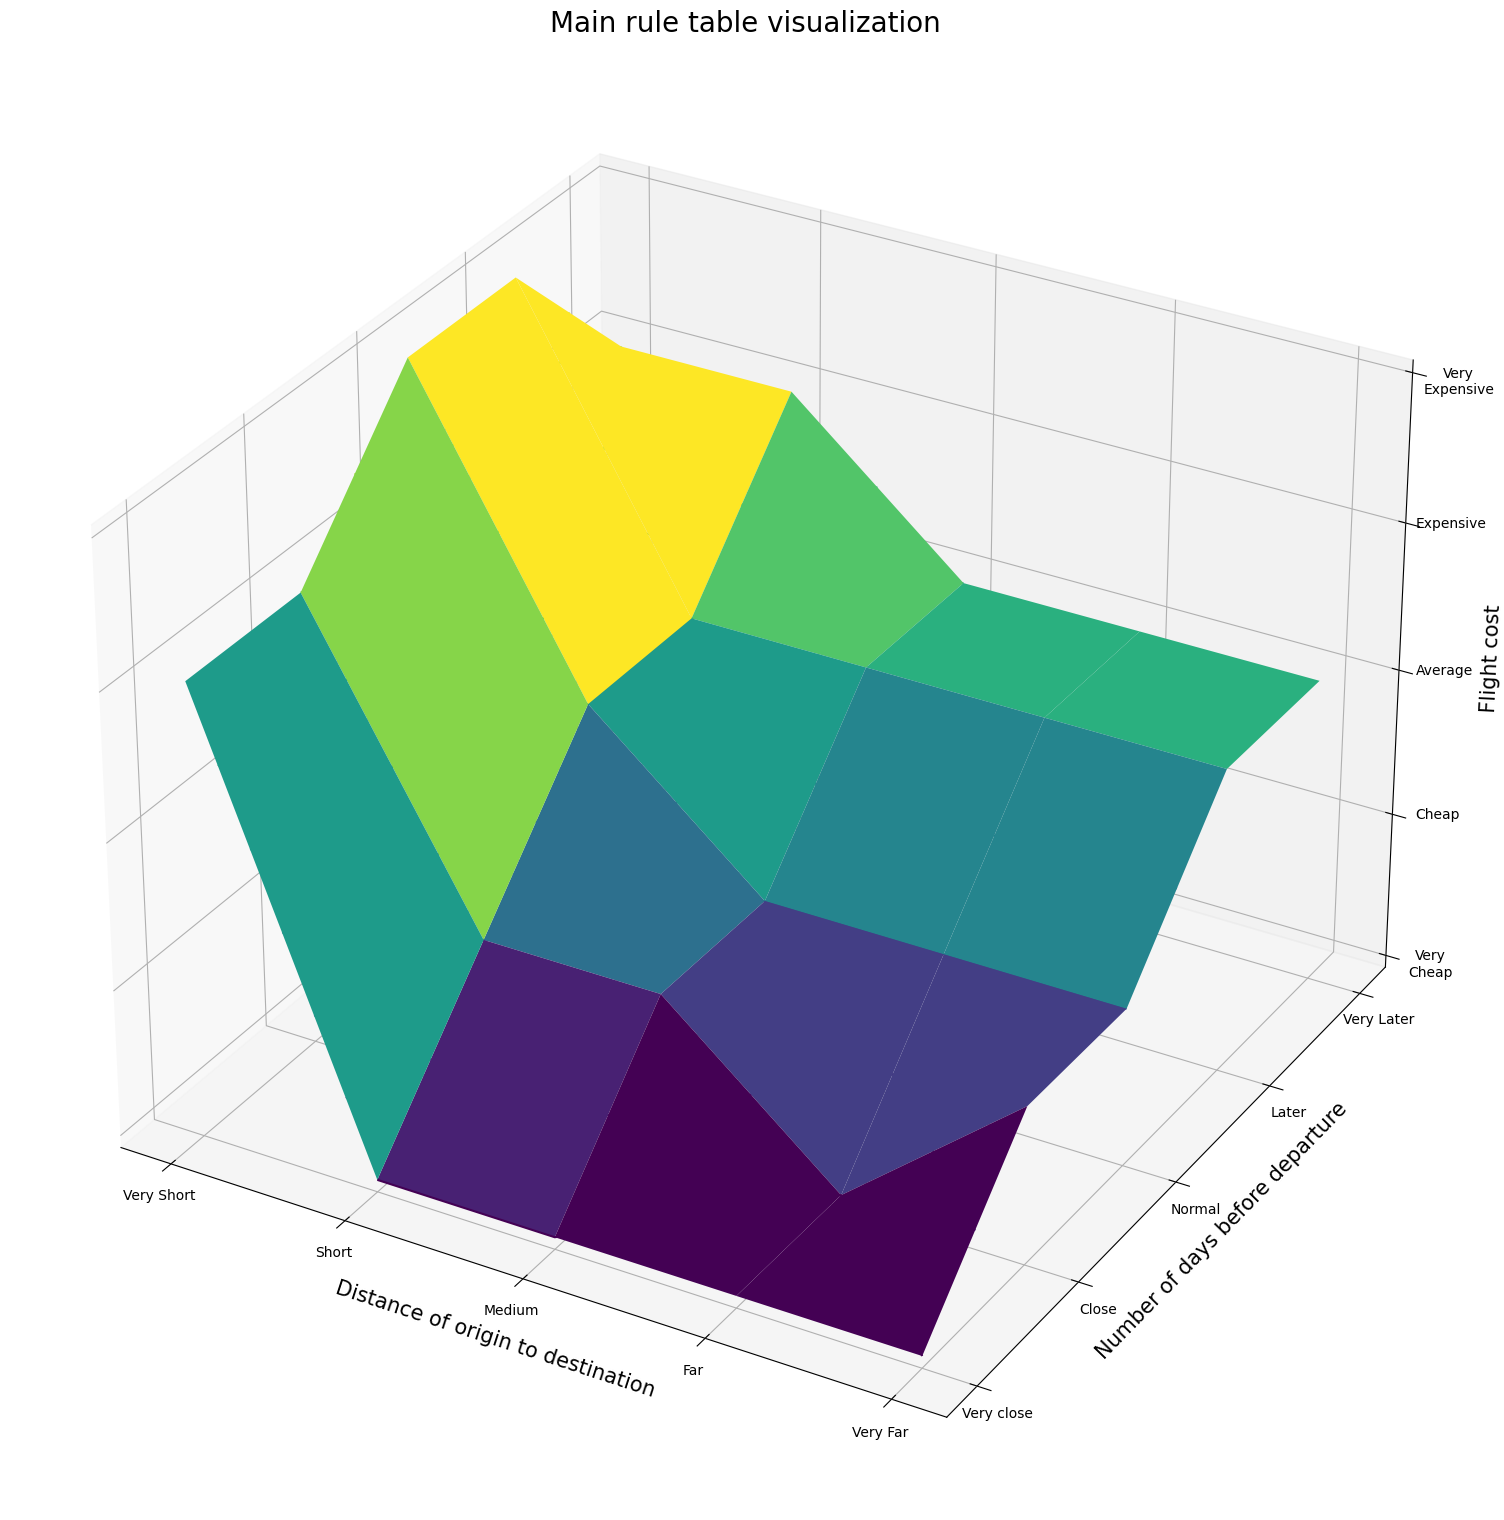

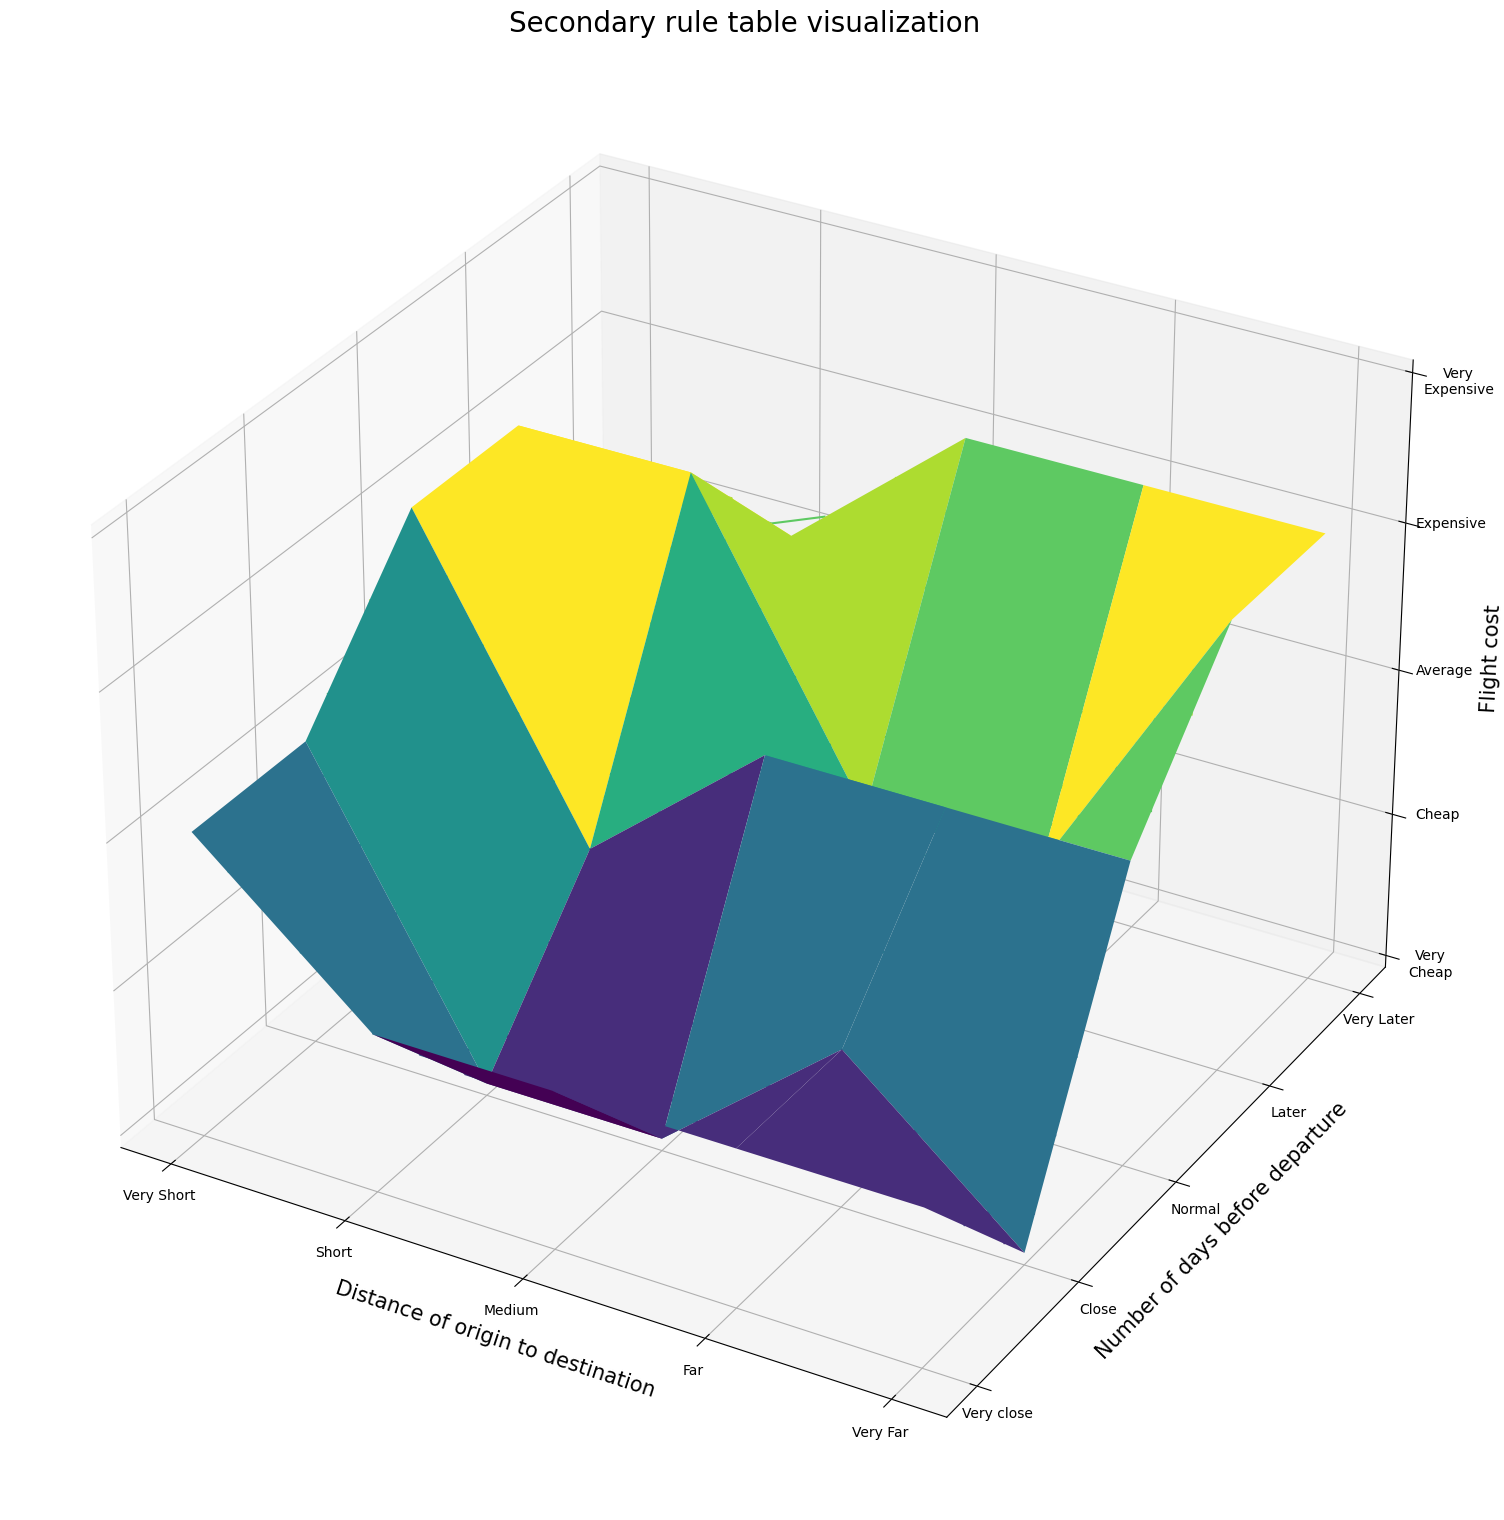

In [29]:
%matplotlib inline
def convert_label_to_int(label):
  res = 0
  if label =="L":
    res = 5
  if label == "ML":
    res = 4
  if label == "M":
    res = 3
  if label == "MS":
    res = 2
  if label == "S":
    res = 1
  return res

# We can simulate at higher resolution with full accuracy
def plot_table(x, y, z, title):
  # Plot the result in pretty 3D with alpha blending
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting

  fig = plt.figure(figsize=(15, 15))
  axes = fig.add_subplot(projection="3d")
  axes.plot_surface(x, y, z,cmap="viridis")
  plt.tight_layout()
  plt.xticks([1,2,3,4,5], ["Very Short", "Short", "Medium", "Far", "Very Far"])
  plt.yticks([1,2,3,4,5], ["Very close", "Close", "Normal", "Later", "Very Later"])
  plt.xlabel("Distance of origin to destination", fontsize=15)
  plt.ylabel("Number of days before departure", fontsize=15)
  plt.tick_params(axis='x', pad=5)
  plt.tick_params(axis='y', pad=5)
  axes.set_zlim3d(1, 5)
  axes.set_zticks([1,2,3,4,5])
  axes.set_zticklabels(["Very\nCheap", "Cheap", "Average", "Expensive", "Very\nExpensive"])
  axes.set_zlabel("Flight cost", fontsize=15)
  axes.tick_params(axis='z', pad=12)
  axes.zaxis.labelpad = 20
  axes.xaxis.labelpad = 10
  axes.yaxis.labelpad = 10
  plt.contour(x, y, z,cmap="viridis")
  plt.title(title, fontsize=20)
  plt.show()

x, y = np.meshgrid(x_orig2, y_orig2)
z_1= np.zeros_like(x)
z_2= np.zeros_like(x)
# Loop through the system 21*21 times to collect the control surface
for i in range(5):
  for j in range(5):
    res_1 = convert_label_to_int(z_dict[i+1][j+1])
    res_2 = convert_label_to_int(z_dict2[i+1][j+1])
    z_1[i,j] = res_1
    z_2[i,j] = res_2
plot_table(x, y, z_1, "Main rule table visualization")
plot_table(x, y, z_2, "Secondary rule table visualization")